# Environment setup

In [ ]:
# Mount your Google Drive to this notebook
# The purpose is to allow your code to access to your files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change the directory to your own working directory
# Your code will be able to read & write files in your working directory
# TO DO: If needed, edit the 'chdir' line to provide your Google-Drive␣directory name
import os
# os.chdir('/content/drive/My Drive/Colab Notebooks')
os.chdir('/content/drive/My Drive/1masters/Computer vision/CV Team Project/Data/')


In [ ]:
# Import library modules
import sys
import cv2 # OpenCV library
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image # PIL is the Python Imaging Library

# The following is a substitute for cv2.imshow,
#  which you would use on your local machine but Colab does not support it
from google.colab.patches import cv2_imshow

print('Python version:', sys.version)
print('OpenCV version:', cv2.__version__)
print('NumPy version: ', np.__version__)


Python version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
OpenCV version: 4.8.0
NumPy version:  1.23.5


#Getting started

Several image files have been provided to you as part of this assignment: mandrill.png, Rubiks_cube.jpg, image1.png, image2.png. Upload all of them to your working directory.

The following functions are helpful for loading images into floating-point format, and for displaying images that are in that format.  Use those functions to verify that the files can be accessed and displayed. Notice that you can adjust the size of the figure that is displayed.


In [ ]:
def load_image(filename):
  img = np.asarray(Image.open(filename))
  img = img.astype("float32")/255.0
  return img

def show_image(img):
  fig = plt.figure()
  fig.set_size_inches(8, 6) # You can adjust the size of the displayed figure
  plt.imshow(img)

# # A mandrill is “a large fierce gregarious baboon of western Africa”
# mandrill_image = load_image('mandrill.png')
# # The next image file is a screen-shot from Virginia Dept. of Transportation's
# #  publicly available traffic videos, https://www.511virginia.org/
# image1 = load_image("image1.png")
# # The next image file is from Google Earth, and it has an "alpha" channel in addition to RGB channels;
# #  the following lines remove the alpha channel from our internal representation
# image2 = load_image("image2.png")

# print(image1.shape)
# print(image2.shape)
# image2 = cv2.cvtColor(image2, cv2.COLOR_BGRA2RGB)
# print(image2.shape)



# show_image(mandrill_image)
# show_image(image1)
# show_image(image2)


**a) 2D homography**

1.   **compute_homography(src, dst)** receives two matrices, each of size Nx2. Each matrix contains N two-dimensional points. For each value of i, src[i] and dst[i] are corresponding points from two different images. The function should return the homography matrix H of size 3x3 that maps every point from the source (src) to the destination (dst). You may assume that N is at least 4. For more guidance, refer to Problem 4 in this assignment.
2.   **apply_homography(src, H)** receives points in matrix named src (an Nx2 matrix), and a homography transformation H (a 3x3 matrix). This function should use the homography matrix to transform each point in src to a new destination point. Store the resulting points in matrix dst, which is the same size as src. The function should return dst.



In [ ]:
def compute_homography(src, dst):
  '''Computes the homography from src to dst.
   Input:
    src: source points, shape (N, 2), where N >= 4
    dst: destination points, shape (N, 2)
   Output:
    H: homography from source points to destination points, shape (3, 3)
  '''
  x = src[:,0]
  y = src[:,1]
  xT = dst[:,0]
  yT = dst[:,1]
  N = len(x)

  A = np.zeros([2*N,9])

  j = 0
  for i in range(0,N*2,2):
    A[i,:] = [-x[j], -y[j], -1, 0, 0, 0, xT[j]*x[j], xT[j]*y[j], xT[j]]
    A[i+1,:] = [0, 0, 0, -x[j], -y[j], -1, yT[j]*x[j], yT[j]*y[j], yT[j]]

    j = j + 1

  w, v = np.linalg.eigh(A.T @ A)
  h = v[:,0]/v[-1,0]
  H = np.reshape(h,[3,3])
  # print(h)
  # print(H)
  return H

# H = compute_homography(src,dst)

##############################
# TO DO: Implement the apply_homography function

def apply_homography(src, H):
  '''Applies a homography H to the source points.
   Input:
      src: source points, shape (N, 2)
      H: homography from source points to destination points, shape (3, 3)
   Output:
     dst: destination points, shape (N, 2)
  '''
  N = src.shape[0]

  src = np.append(src,np.ones([N,1]),1)

  dst = H @ src.T

  dst = dst/dst[2,:]

  return dst.T[:,:2]


def warp_img(src_img, H, dst_img_size):
  '''Warping of a source image using a homography.
   Input:
      src_img: source image with shape (m, n, 3)
      H: homography, with shape (3, 3), from source image to destination image
      dst_img_size: height and width of destination image; shape (2,)
   Output:
      dst_img: destination image; height and width specified by dst_img_size parameter
  '''
  ####### try 2

  Hinv = np.linalg.inv(H)
  dst_img = np.zeros((dst_img_size[0], dst_img_size[1]))
  # dst_img = np.zeros((dst_x, dst_y))

  dst = np.zeros((1,2))
  for i in range(dst_img_size[0]):
    for j in range(dst_img_size[1]):
      dst[0,:] = [i, j]
      src = apply_homography(dst, Hinv)
      # print(src.shape)
      src = np.int32(np.round(src))
      #if (src[0,0] >= 0 and src[0,1] >= 0 and src[0,0] < dst_img_size[0] and src[0,1] < dst_img_size[1]):
      if (src[0,0] >= 0 and src[0,1] >= 0 and src[0,0] < src_img.shape[0] and src[0,1] < src_img.shape[1]):
        dst_img[i,j] = src_img[src[0,0], src[0,1]]
      else:
        dst_img[i,j] = 0

  return dst_img

In [ ]:
def binary_mask(img):
  '''Create a binary mask of the image content.
   Input:
    img: source image, shape (m, n, 3)
   Output:
    mask: image of shape (m, n) and type 'int'. For pixel [i, j] of mask,
      if pixel [i, j] in img is nonzero in any channel, assign 1 to mask[i, j].
      Else, assign 0 to mask[i, j].
  '''
  #mask = (img[:, :, 0] > 0) | (img[:, :, 1] > 0) | (img[:, :, 2] > 0)
  mask = (img > 0)
  mask = mask.astype("int")

  print("mask.shape",mask.shape)
  return mask

# def test_warp():
#   src_img = load_image('mandrill.png')
#   canvas_img = load_image('Rubiks_cube.jpg')

#   # The following are corners of the mandrill image in (ROW, COLUMN) order
#   src_pts = np.matrix('0, 0; 511, 0; 511, 511; 0, 511')
#   # The following are corners of the blue face of the Rubik's cube
#   canvas_pts = np.matrix('238, 218; 560, 225; 463, 490; 178, 530')

#   # The following was used during debugging
#   # It draws a circle at a location specified by (COLUMN, ROW)
#   #cv2.circle(canvas_img, (530, 178), 4, (255, 0, 0), thickness=10)

#   #H = compute_homography(src_pts, canvas_pts)
#   H1, H2 = cv2.findHomography(src_pts, canvas_pts)
#   dst_img = warp_img(src_img, H1, [canvas_img.shape[0], canvas_img.shape[1]])

#   dst_mask = 1 - binary_mask(dst_img)
#   dst_mask = np.stack((dst_mask,) * 3, -1)
#   out_img = np.multiply(canvas_img, dst_mask) + dst_img
#   show_image(out_img)
#   dsize = (600, 600) # width and height of canvas_im
#   src_smaller = cv2.resize(src_img, dsize, interpolation=cv2.INTER_AREA)

#   warped_img = np.concatenate((src_smaller, canvas_img, out_img), axis=1)
#   show_image(np.clip(warped_img, 0, 1))

# test_warp()

(814, 1280, 4)
(640, 640, 3)


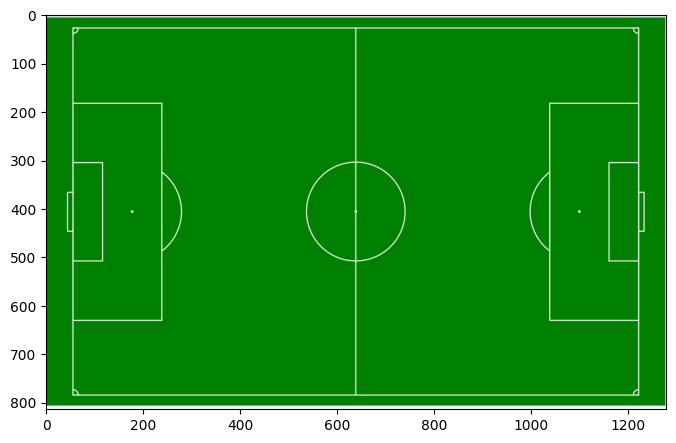

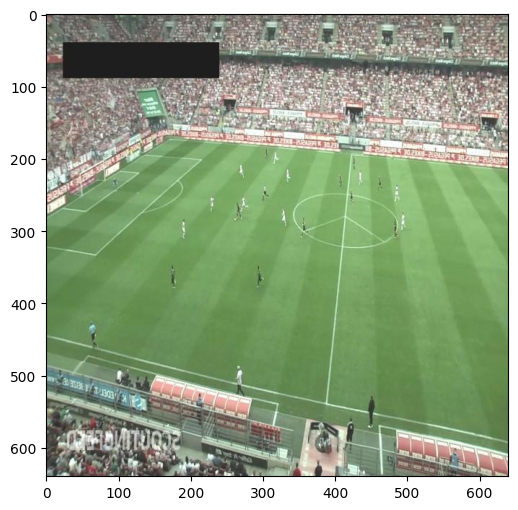

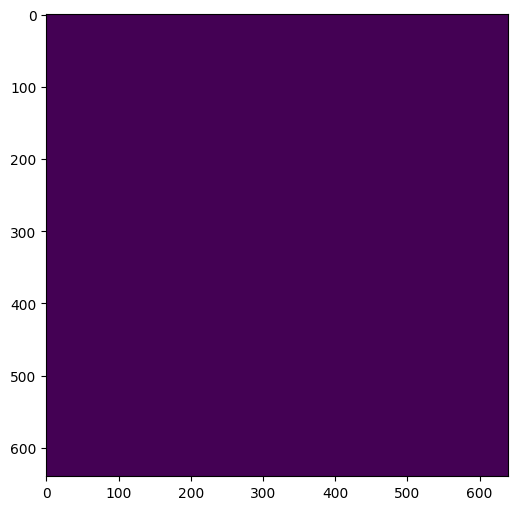

In [ ]:
# src_pts2 = np.matrix('57, 177; 239, 177; 239, 625; 640, 401; 640, 23; 640, 778')

# canvas_pts2 = np.matrix('134, 196; 214, 202; 68, 334; 414, 282; 423, 194; 388, 540')

# src_pts2 = np.matrix('239, 177; 239, 625; 640, 23; 640, 778')

# canvas_pts2 = np.matrix('214, 202; 68, 334; 423, 194; 388, 540')

src_pts2 = np.matrix('177, 239; 625, 239; 23, 640; 778, 640')

canvas_pts2 = np.matrix('202, 214; 334, 68; 194, 423; 540, 388')

pitch_image = load_image("HomographyTestImages/field_images/pitch.png")

# src_pts2_tuples = [tuple(map(int, row.tolist()[0])) for row in src_pts2]

# canvas_pts2_tuples = [tuple(map(int, row.tolist()[0])) for row in canvas_pts2]

# for point in src_pts2_tuples:
#   cv2.circle(pitch_image, point, 10, (0, 1, 0), thickness=-1)


show_image(pitch_image)

print(pitch_image.shape)

pitch_image2 = load_image('HomographyTestImages/field_images/scene00251.jpg')

# for point in canvas_pts2_tuples:
#   cv2.circle(pitch_image2, point, 10, (0, 1, 0), thickness=-1)

print(pitch_image2.shape)

show_image(pitch_image2)

black_image = np.zeros((640, 640))

show_image(black_image)


In [ ]:
def bev2(im1, src_pts, canvas_pts, im2shape):

  image1 = load_image(im1)
  image2 = black_image = np.zeros(im2shape) # TODO this should be img2 shape

  gray_image = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

  ksize = (3,3) #(5,5)#(11,11)  # Specify the kernel size, (5, 5) is just an example
  image1 = cv2.GaussianBlur(gray_image, ksize, 0)

  #image1 = cv2.cvtColor(image1, cv2.COLOR_BGRA2RGB)
  #image2 = cv2.cvtColor(image2, cv2.COLOR_BGRA2RGB)


  H = compute_homography(src_pts, canvas_pts)

  dst_img = warp_img(image1, H, [image2.shape[0], image2.shape[1]])

  # print("dst_img.shape", dst_img.shape)

  dst_mask = 1 - binary_mask(dst_img)

  #dst_mask = np.stack((dst_mask,) * 3, -1)
  # print("image2.shape", image2.shape)
  # print("dst_mask.shape", dst_mask.shape)

  out_img = np.multiply(image2, dst_mask) + dst_img

  # show_image(out_img)
  warped_pitch = out_img
  thresholdvalue = 0.4
  _, binary_image = cv2.threshold(warped_pitch, thresholdvalue, 1, cv2.THRESH_BINARY)
  warped_pitch2 = binary_image*255
  warped_pitch3 = warped_pitch2.astype(np.uint8)
  adap_warped_image = cv2.adaptiveThreshold(warped_pitch3, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 11, 4)

  fig = plt.figure()
  plt.imshow(adap_warped_image)

  return(adap_warped_image)


# Illustrate keypoint matching between 2 images
def genSIFTMatchPairs(img1, img2, numberOfMatches, sigma, edgeThreshold, nOctaveLayers):
  # Find keypoints and their SIFT descriptors in the two images
  sift = cv2.SIFT_create(sigma=sigma, nOctaveLayers=nOctaveLayers, edgeThreshold=edgeThreshold)

  # show_image(img1)
  # show_image(img2)

  kp1, des1 = sift.detectAndCompute(img1, None)
  kp2, des2 = sift.detectAndCompute(img2, None)

  # Search for corresponding pairs of points
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  matches = bf.match(des1, des2)

  # Sort correspondences based on distance (dissimilarity) between two descriptors
  matches = sorted(matches, key = lambda x:x.distance)

  pts1 = np.zeros((numberOfMatches, 2))
  pts2 = np.zeros((numberOfMatches, 2))

  for i in range(numberOfMatches):
    pts1[i,:] = kp1[matches[i].queryIdx].pt
    pts2[i,:] = kp2[matches[i].trainIdx].pt
  return pts1, pts2, matches[:numberOfMatches], kp1, kp2

def matchingProcedure(img1, img2, numberOfMatches, sigma, edgeThreshold, nOctaveLayers):
  # Perform the matching step (here, only the best 20 correspondences are returned)
  pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(img1, img2, numberOfMatches, sigma, edgeThreshold, nOctaveLayers)

  return pts1, pts2, matches1to2, kp1, kp2

# Convert the segmented image to grayscale and then apply Canny edge detection
# segmented_pitch_gray = cv2.cvtColor(segmented_pitch_m, cv2.COLOR_BGR2GRAY)
# Define HSV range for green color to segment the pitch
# These values may need to be adjusted for different lighting conditions and pitch colors

def adapativeThresholdMask(input_image):
  hsv_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2HSV)

  green_lower_hsv = np.array([30, 40, 40])

  green_upper_hsv = np.array([90, 255, 255])

  # Create a binary mask where green pixels are white and all other pixels are black
  pitch_mask = cv2.inRange(hsv_image, green_lower_hsv, green_upper_hsv)

  # Apply morphological operations to enhance the lines
  kernel = np.ones((3,3),np.uint8)
  pitch_mask = cv2.morphologyEx(pitch_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
  pitch_mask = cv2.morphologyEx(pitch_mask, cv2.MORPH_OPEN, kernel, iterations=3)


  # Apply the mask to the original image to segment out the pitch
  segmented_pitch = cv2.bitwise_and(input_image, input_image, mask=pitch_mask)

  # segmented_pitch_m = np.mean(segmented_pitch, axis=2).astype(np.uint8)
  segmented_pitch_m = cv2.cvtColor(segmented_pitch, cv2.COLOR_RGB2GRAY).astype(np.uint8)

  blurred_image = cv2.GaussianBlur(segmented_pitch_m, (3,3), 0)
  # binary_image = blurred_image.astype(np.uint8)

  # # Adaptive Thresholding
  binary_image = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 11, 2)

  binary_image = binary_image.astype(np.uint8)


  return binary_image

def readImages(filecount):
  '''Read a sequence of image files, starting with image 0 in 'hotel' sequence
     Input:
      filecount: how many image files to read
     Output:
      allImages: a list of OpenCV images in sequential order
  '''
  # print("In function readImages")
  allImages = []
  for i in range(1,filecount+1):
    tmp = "mancityVtottenham/scene" + f'{(i-1+2)*125+1:05d}' + ".png"
    # tmp = "HomographyTestImages/field_images/scene" + f'{(i-1+2)*125+1:05d}' + ".jpg"

    print(tmp)
    imagetmp = cv2.imread(tmp)
    # cv2_imshow(imagetmp)
    # print(imagetmp.shape)
    allImages.append(imagetmp)
  return allImages

def testMatchingProcedure(img1, img2, best_cor, sigma, edgeThreshold, nOctaveLayers):

  # Perform the matching step (here, only the best 20 correspondences are returned)
  pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(img1, img2, best_cor, sigma, edgeThreshold, nOctaveLayers)

  # Now pts1 and pts2 should contain lists of corresponding points
  #  within img1 and img2, respectively; each point has the format [column row]
  # For exploring and debugging, you can print the corresponding pairs of points
  for match_i in matches1to2:
    p1 = kp1[match_i.queryIdx].pt
    p2 = kp2[match_i.trainIdx].pt
    print(p1, p2)

  # Display the two images to check the results visually
  #  (parameter flags=2 removes unmatched points from the display)
  matching_result = cv2.drawMatches(img1, kp1, img2, kp2, matches1to2, None, flags=2)

  matching_result2 = cv2.drawMatches(img1, kp1, img2, kp2, matches1to2, None, flags=4)
  fig = plt.figure()
  fig.set_size_inches(16, 10) # You can adjust the size of the displayed figure
  plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))

  fig = plt.figure()
  fig.set_size_inches(16, 10) # You can adjust the size of the displayed figure
  plt.imshow(cv2.cvtColor(matching_result2, cv2.COLOR_BGR2RGB))

# img1 = cv2.imread('HW4/stopsign_images/stopsign01.jpg')
# img2 = cv2.imread('HW4/stopsign_images/image01.jpg')

# testMatchingProcedure(img1, img2)

in findField
mancityVtottenham/scene00251.png
mancityVtottenham/scene00376.png
number of images that were read = 2
(189.88034057617188, 331.34228515625) (1888.9130859375, 1007.6368408203125)
(1219.125244140625, 584.2044677734375) (1198.7384033203125, 689.5346069335938)
(1021.3934326171875, 594.3901977539062) (1223.410888671875, 452.16790771484375)
(319.39422607421875, 470.8243713378906) (493.3190002441406, 451.7149963378906)
(298.35516357421875, 495.1171569824219) (473.4265441894531, 472.98114013671875)
(1075.6846923828125, 491.3196716308594) (1223.410888671875, 452.16790771484375)
(298.5333557128906, 512.0674438476562) (473.43170166015625, 490.3799133300781)
(198.28753662109375, 615.9190673828125) (367.7750244140625, 592.7333374023438)
(1022.9708251953125, 441.9530029296875) (1223.410888671875, 452.16790771484375)
(319.39422607421875, 470.8243713378906) (493.3190002441406, 451.7149963378906)
t ======  63.38075256347656
diffErr	nInliers
0 	 [  0.       815.05743  814.21014    0.       

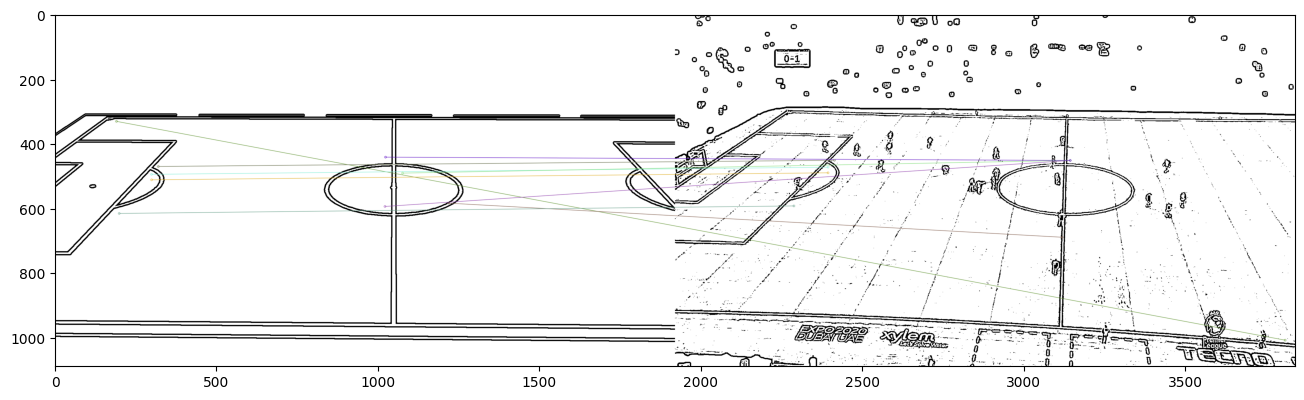

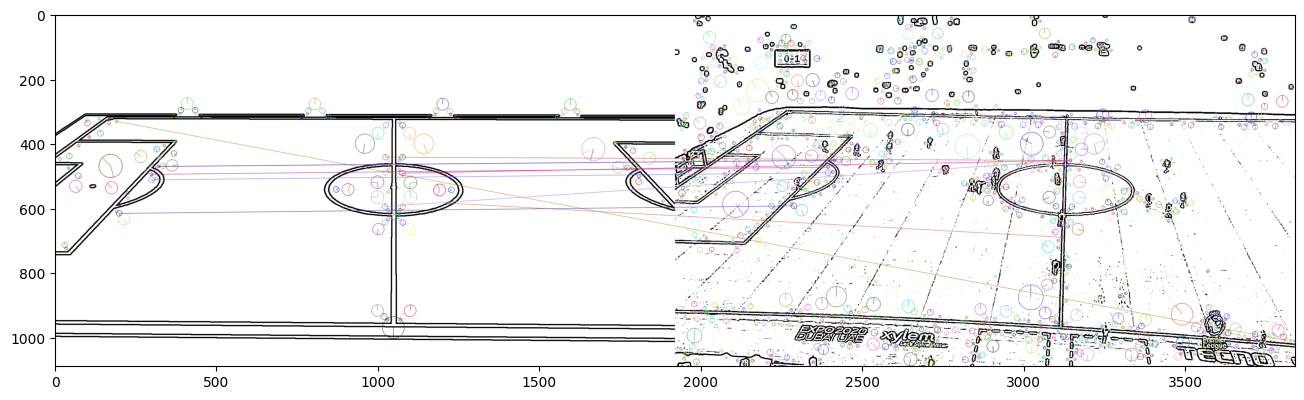

<Figure size 640x480 with 0 Axes>

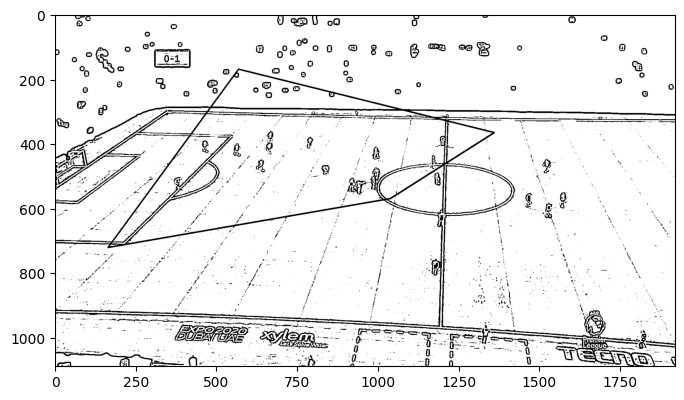

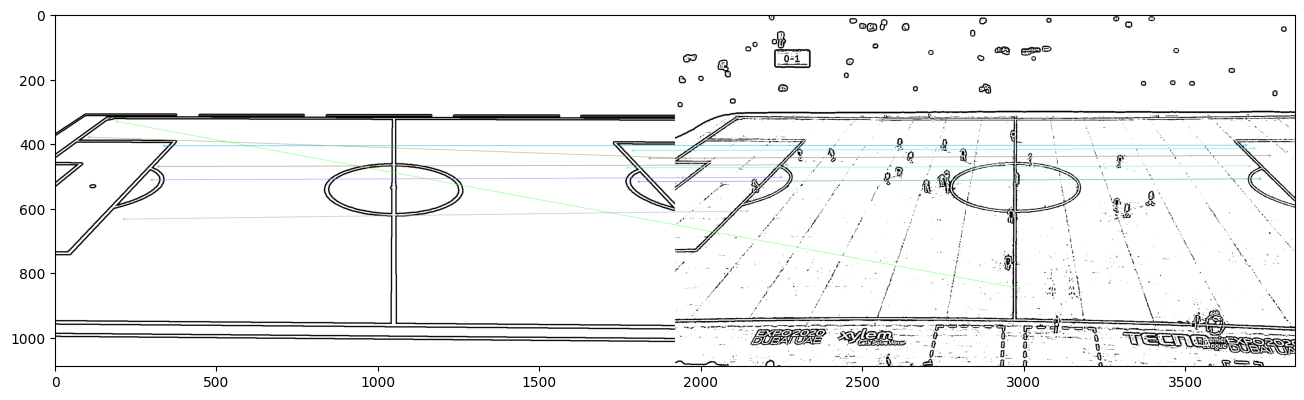

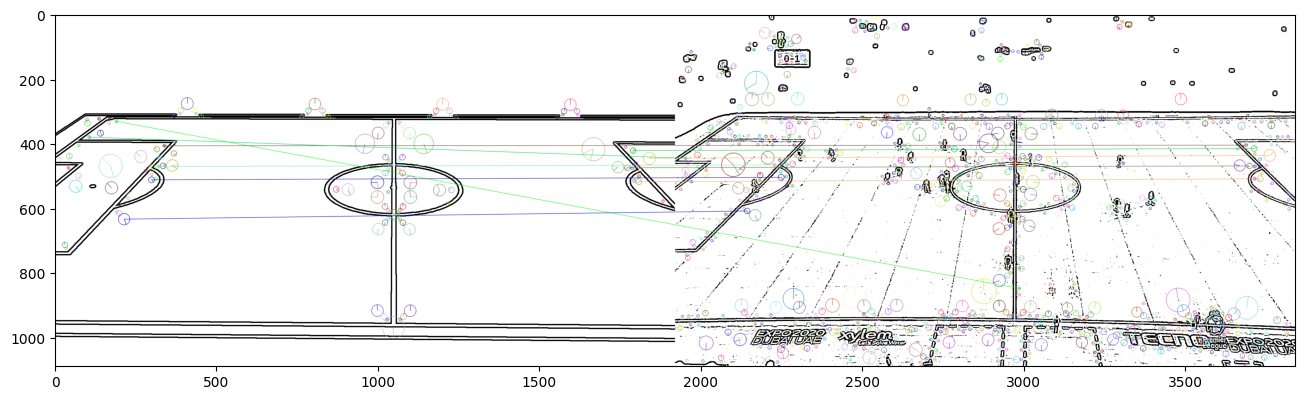

<Figure size 640x480 with 0 Axes>

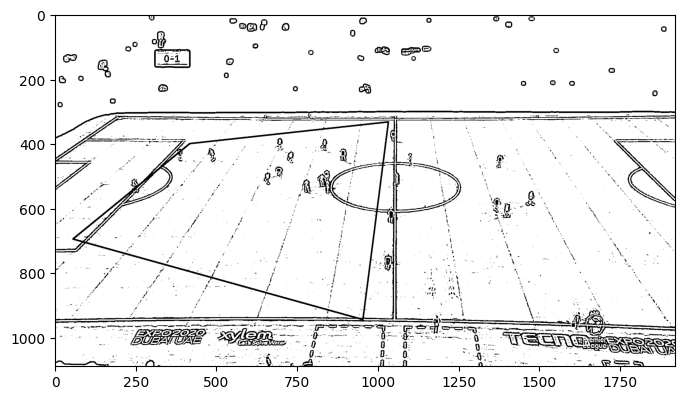

In [ ]:
YELLOW = (0,255,255)
NUMBER_OF_IMAGES = 2 #10
NMatches = 30
NRansac = 10000  # iterations
s = 4       # pairs
# inlier matches. the "s" pairs you used to make the homography obviously don't count
d = 3 # 4 #np.round((NMatches-s)*0.55)
NRansac = 100
NMatches = 10
SIFTsigma = 5# 10 #7
edgeThreshold = 20
nOctaveLayers = 1

# def findField():
  # '''Examine a set of images and report locations of stop signs within those images.
  #    SIFT descriptors are used in the decision-making process.
  #  Input:
  #   <No input parameters. Image file names are hard-coded.>
  #  Output:
  #   <No return value. Output is provided using print statements and by displaying images.>
  # '''
print('in findField')
allImgs = readImages(NUMBER_OF_IMAGES)
print (f'number of images that were read = {len(allImgs)}')
NImg = len(allImgs)
isField = np.zeros((NUMBER_OF_IMAGES,1),dtype=bool)

# plt.figure()
# plt.imshow(allImgs[0])

# img1 = cv2.imread("HomographyTestImages/field_images/pitch.png", cv2.COLOR_BGR2GRAY)
# #### points for first image I tried
# src_pts2 = np.matrix('177, 239; 625, 239; 23, 640; 778, 640')
# canvas_pts2 = np.matrix('202, 214; 334, 68; 194, 423; 540, 388')
### points for video demo
src_pts2 = np.array([[778, 640],[625, 239], [177, 239], [23, 640]])
canvas_pts2 = np.array([[950,1050],[733,50],[390,375],[320,1050]])
img2shape = allImgs[0].shape
# img1 = bev2("HomographyTestImages/field_images/pitch.png", src_pts2, canvas_pts2, img2shape[0:2])

for i in range(NImg):
  img2 = allImgs[i]
  # img2 = cv2.imread("HomographyTestImages/field_images/scene00251.jpg")
  # adaptive threshold each image
  # plt.figure();
  # cv2_imshow(img2)
  img2 = adapativeThresholdMask(img2)
  # detect kp in ref image
  # detect kp in test image
  # perform kp matching between 2 images
  # pts1, pts2, matches1to2, kp1, kp2 = matchingProcedure(img1,img2,NMatches,SIFTsigma, edgeThreshold, nOctaveLayers)
  pts1, pts2, matches1to2, kp1, kp2 = matchingProcedure(img1,img2,NMatches,SIFTsigma, edgeThreshold, nOctaveLayers)
  testMatchingProcedure(img1, img2, NMatches, SIFTsigma, edgeThreshold, nOctaveLayers)
  # to attempt to increase "scale invariance," I made the threshold relative
  # to the spread of the detected keypoints
  t = np.max(
              [np.max(pts2[:,0]) - np.min(pts2[:,0]),
              np.max(pts2[:,1]) - np.min(pts2[:,1])]
  )/4.0/6.0
  # t = np.median(
  #             [np.median(np.abs(pts2[:,0] - np.median(pts2[:,0]))),
  #             np.median(np.abs(pts2[:,1] - np.median(pts2[:,1])))]
  # )/4.0
  print("t ====== ", t)
  # # To improve invariance to scale, make threshold parameter "t" 1/3 of the
  # # absolute difference from the median of the keypoint locations.
  #   # Note: Median chosed since it is  less affected by outliers than std deviation or
  #   # mean
  # t = 15
  # print('t: ', t)

  success = False
  print("diffErr\tnInliers")
  # Repeat N times
  for j in range(NRansac):
    # randomly select "s" pairs of kp's
    picks = np.random.permutation(NMatches)
    picks = picks[0:s]
    # use the pairs to solve for homography mapping ref to test
    H = compute_homography(pts1[picks,:], pts2[picks,:])
    # print(pts1[picks,:])


    # find in inliers to this model from remaining correspondences
    # i.e. your tf from prior step maps the point from ref to test within
    # threshold distance "t"

    pts2TF = apply_homography(pts1, H)

    diff = np.float32(pts2TF) - np.float32(pts2)
    diffsq = np.square(diff)
    diffErr = np.sqrt(np.sum(diffsq,axis=1))
    # print("diffErr:", diffErr)
    inliersIdx = diffErr < t
    nInliers = np.sum(inliersIdx) - 4
    print(nInliers,"\t", diffErr)

    # if n inliers is larger than "d", recompute homography using all of the inliers
    if nInliers >= d:
      success = True

      break

  if success:
    print('(',i+1,'/',NImg,') Found Field')
    isField[i] = True
    # recompute homography w/ all inliers
    H = compute_homography(pts1[inliersIdx, :], pts2[inliersIdx, :])
    # print("Homography: \n", H)
    print("H\n\n",H,"\n\n")

    FieldPlot = img2
    # corners = np.array([[1,1],[img1.shape[1]-1,1],[img1.shape[1]-1,img1.shape[0]-1],[1,img1.shape[0]-1],[1,1]])
    cornersFlip = np.zeros((5,2))
    cornersFlip[0:4,:] = canvas_pts2
    cornersFlip[4,:] = canvas_pts2[0,:]
    # print(cornersFlip)
    corners = np.zeros((5,2))
    corners[:,0] = cornersFlip[:,1]
    corners[:,1] = cornersFlip[:,0]
    cornersTF = apply_homography(corners, H)
    # print("corners\n", corners)
    # print("cornersTF\n", cornersTF)

    for k in range(4):
      cv2.line(FieldPlot, np.intp(cornersTF[k,:]), np.intp(cornersTF[k+1,:]), YELLOW, 3)

    # cv2_imshow(FieldPlot)
    plt.figure()
    FieldPlot = cv2.cvtColor(FieldPlot, cv2.COLOR_BGR2RGB)
    show_image(FieldPlot)

  else:
    print('(',i+1,'/',NImg,') NO FIELD :(')
    isField[i] = False
    cv2_imshow(img2)
    # img2plot = cv2.cvtColor(signPlot, cv2.COLOR_BGR2RGB)
    # show_image(img2plot)
print("All done!")



in findField
mancityVtottenham/scene00251.png
mancityVtottenham/scene00376.png
number of images that were read = 2


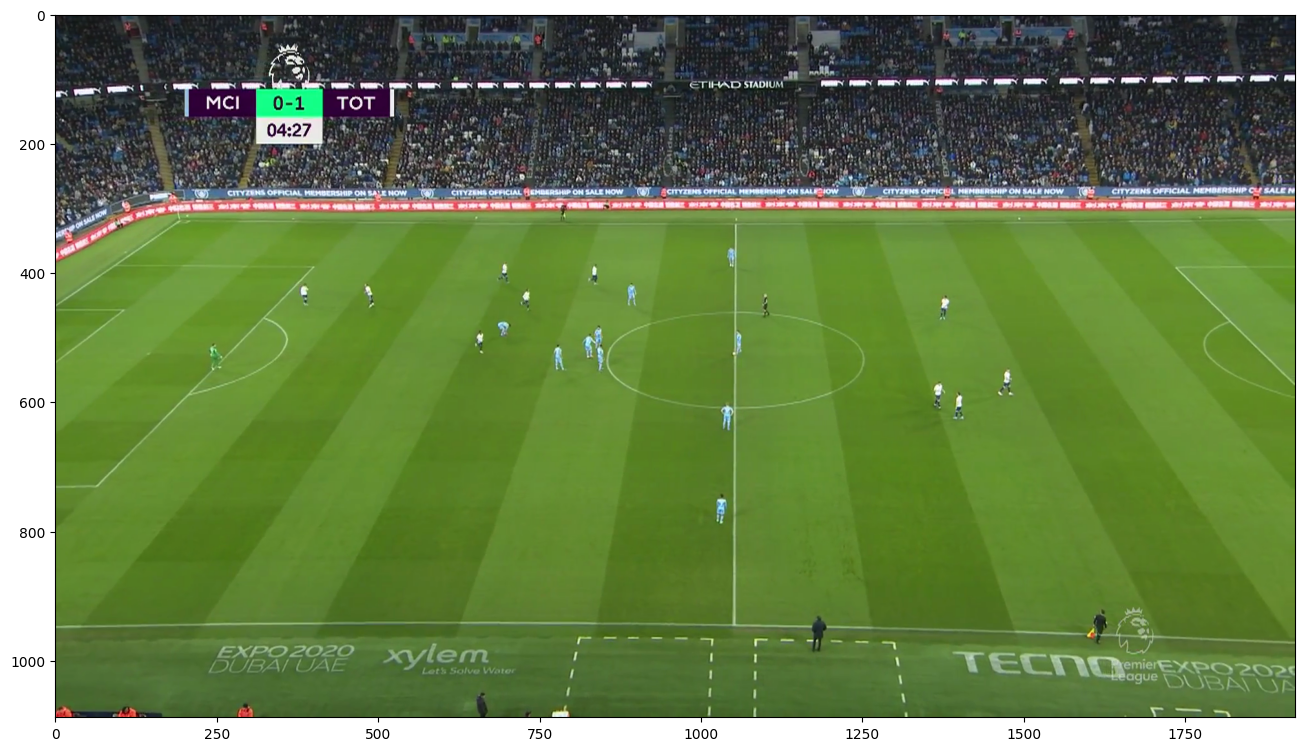

In [ ]:
print('in findField')
allImgs = readImages(NUMBER_OF_IMAGES)
print (f'number of images that were read = {len(allImgs)}')
NImg = len(allImgs)
isField = np.zeros((NUMBER_OF_IMAGES,1),dtype=bool)

fig = plt.figure()
fig.set_size_inches(16, 10) # You can adjust the size of the displayed figure
plt.imshow(cv2.cvtColor(allImgs[1], cv2.COLOR_BGR2RGB))

[950,1050],[733,50],[390,375],[320,1050]